# Bert Analytics

## Imports

In [1]:
!pip install transformers datasets evaluate wandb umap-learn hdbscan minicons seaborn

In [1]:
import datasets
import transformers

from transformers import (
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    AutoModelForMaskedLM,
)

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import trange, tqdm
import pandas as pd
import numpy as np
import minicons.scorer
from mlm_scoring import ppl_mlm_score
from functools import partial, partialmethod
import pickle
import pathlib


import umap
from matplotlib import pyplot as plt
import hdbscan
import seaborn as sns

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

from MinioHandler import MinioHandler

In [3]:
minio = MinioHandler()

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

## Parameters

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [14]:
SEQ_LEN = 64
BATCH_SIZE = 16

DATA_PATH = '../data/test_dataset.csv'
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
WEIGHTS_PATH = "ckpt/trained_models/naive_cosine_with_pretrained_bert_with_ema_0.999/model.pt"

## Data Preparation

In [23]:
df = pd.read_csv(DATA_PATH, index_col=0)
df.drop(columns=["was_changed"], inplace=True)
data = datasets.Dataset.from_pandas(df, preserve_index=False)

# data = data.train_test_split(test_size=TEST_SIZE)

In [24]:
data

Dataset({
    features: ['base', 'polypers', 'was_changed'],
    num_rows: 229849
})

In [ ]:
# tokenizer.pad_token = '[SEP]'
# tokenizer.eos_token = '[SEP]'
# data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=MLM_PROB)

## Model

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
model.to(device)
pass

In [51]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [26]:
class PairsDataset(torch.utils.data.Dataset):
    def __init__(self,
                 tokenizer: transformers.AutoTokenizer,
                 path: str=None,
                 data: pd.DataFrame=None,
                 filter_same: bool=True,
                 SEQ_LEN: int=64):
        if data is None:
            data = pd.read_csv(path, index_col=0)
        self.dataset = data[(data.was_changed) | (not filter_same)].reset_index(drop=True)
        self.tokenizer = tokenizer
        self.SEQ_LEN = SEQ_LEN

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx: list[int]):
        text1 = self.tokenizer(self.dataset.loc[idx]['base'],
                     padding='max_length',
                     truncation=True,
                     max_length=self.SEQ_LEN, 
                    return_tensors="pt")

        text2 = self.tokenizer(self.dataset.loc[idx]['polypers'],
                     padding='max_length',
                     truncation=True,
                     max_length=self.SEQ_LEN,
                    return_tensors="pt")

        return text1, text2

In [27]:
dt = PairsDataset(mlm_model.tokenizer, data=df, SEQ_LEN=SEQ_LEN)

In [28]:
dl = DataLoader(dt,
                batch_size=BATCH_SIZE,
                shuffle=False, )

### MLM scoring

In [8]:
BATCH_SIZE = 3
# note : this is the sequence length in terms of words, 
SEQ_LEN = 64

In [8]:
# not needed anymore
# data_cut = data.map(lambda x: {k: " ".join(v.split()[:SEQ_LEN]) for k, v in x.items()})

In [9]:
token_dl = DataLoader(data,
                batch_size=BATCH_SIZE,
                shuffle=False)

In [10]:
mlm_model = minicons.scorer.MaskedLMScorer(
    MODEL_NAME, 'cuda', torch_dtype=torch.float32, )

In [11]:
type(mlm_model.tokenizer)

transformers.models.bert.tokenization_bert_fast.BertTokenizerFast

In [12]:
def override_padding(func):
    def wrapper(*args, **kwargs):
        try:
            del kwargs["max_length"]
            del kwargs["truncation"]
        except:
            pass
        return func(*args, 
                max_length=SEQ_LEN+2,
                truncation=True,
                **kwargs)
    return wrapper

In [13]:
# this step is crusial as otherwise kernel crashes with OOM in case long sentence is passed

SEQ_LEN_tokenizer = type('SEQ_LEN_tokenizer', (type(mlm_model.tokenizer), ), 
                         {"__call__": override_padding(type(mlm_model.tokenizer).__call__,),
                         "encode": override_padding(type(mlm_model.tokenizer).encode),
                         "batch_encode_plus": override_padding(type(mlm_model.tokenizer).batch_encode_plus),
                         })

mlm_model.tokenizer.__class__ = SEQ_LEN_tokenizer

# mlm_model.tokenizer.encode = types.MethodType(partial(mlm_model.tokenizer.encode, max_length=SEQ_LEN), mlm_model.tokenizer, type(mlm_model.tokenizer))
# mlm_model.tokenizer.batch_encode_plus = types.MethodType(partial(mlm_model.tokenizer.batch_encode_plus, max_length=SEQ_LEN), mlm_model.tokenizer, type(mlm_model.tokenizer))

In [16]:
ckpt = minio.get_object(WEIGHTS_PATH, type="model")
model_dict = torch.load(ckpt)

# necessary for averaged models
model_dict["model_state_dict"] = {".".join(k.split(".")[1:]): v for k, v in model_dict["model_state_dict"].items() if ".".join(k.split(".")[1:])}

In [17]:
mlm_model.model.load_state_dict(model_dict["model_state_dict"])
mlm_model.model.eval();

#### Examples

In [78]:
stimuli = ['Маша переигрываетют команду галактических велоцирапторов на их же бурлящем магмой поле.']

In [86]:
# un-normalized sequence score
print(mlm_model.sequence_score(stimuli, reduction = lambda x: -x.sum(0).item(), PLL_metric='within_word_l2r'))

[148.0287103652954]


In [87]:
# un-normalized sequence score
print(mlm_model.sequence_score(stimuli,  PLL_metric='within_word_l2r'))

[-7.04898620787121]


In [88]:
# original metric, for comparison:
print(mlm_model.sequence_score(stimuli, reduction = lambda x: -x.sum(0).item(), PLL_metric='original'))

[123.32754421234131]


In [89]:
# per token mlm score
print(mlm_model.token_score(stimuli, PLL_metric='within_word_l2r'))

[[('Маша', -14.733255386352539), ('переиг', -12.894548416137695), ('##рывает', -1.5674495697021484), ('##ют', -12.331448554992676), ('команду', -10.329864501953125), ('галакт', -9.798038482666016), ('##ических', -0.016702651977539062), ('вело', -13.687272071838379), ('##цир', -6.7924394607543945), ('##апт', -7.651939392089844), ('##оров', -6.568037986755371), ('на', -1.355173110961914), ('их', -7.46560001373291), ('же', -5.223512649536133), ('бур', -9.791799545288086), ('##лящ', -0.029567718505859375), ('##ем', -0.15289306640625), ('маг', -10.546503067016602), ('##мой', -15.570703506469727), ('поле', -1.4538021087646484), ('.', -0.06815910339355469)]]


In [90]:
# original values, for comparison (notice the 'souvenir' tokens):
print(mlm_model.token_score(stimuli, PLL_metric='original'))

[[('Маша', -14.733255386352539), ('переиг', -11.954214096069336), ('##рывает', -8.466730117797852), ('##ют', -12.331448554992676), ('команду', -10.329864501953125), ('галакт', -3.4973182678222656), ('##ических', -0.016702651977539062), ('вело', -5.904531478881836), ('##цир', -5.439380645751953), ('##апт', -9.758092880249023), ('##оров', -6.568037986755371), ('на', -1.355173110961914), ('их', -7.46560001373291), ('же', -5.223512649536133), ('бур', -0.0006656646728515625), ('##лящ', -4.9591064453125e-05), ('##ем', -0.15289306640625), ('маг', -3.0374088287353516), ('##мой', -15.570703506469727), ('поле', -1.4538021087646484), ('.', -0.06815910339355469)]]


Test dataset scoring

In [65]:
list(
    zip(
    data["base"][:20], 
         mlm_model.sequence_score(data["base"][:20], reduction = lambda x: -x.sum(0).item(), PLL_metric='within_word_l2r')
    )
)

[('Штурман доложил , что расстояние от « Каймана » до « Колумба » в семь раз короче расстояния от шхуны до эсминца .',
  23.059691429138184),
 ('Я смотрел на топчанчик и не сразу заметил доктора Грейсона , который надевал халат .',
  28.70303773880005),
 ('Пришлось зачеркнуть и " во-первых " и " во-вторых " и написать просто : " потому что каникулы " .',
  41.376718521118164),
 ('Будем растить мастеров своего дела .', 25.77302837371826),
 ('Вам , думается , тоже , а мне-то ведь есть что терять .',
  31.656872272491455),
 ('А каково командиру ?', 14.959938049316406),
 ('Глубина здесь была не столь велика , но течение необыкновенно сильное , вода ледяная и скользкое , покатое дно .',
  47.39584922790527),
 ('Не правда ли , вы заставите , штурмбаннфюрер ?', 26.777738571166992),
 ('Записали о нем в вахтенный журнал .', 12.138683319091797),
 ('А вы — в Трое .', 18.4355411529541),
 ('Очнувшись , я увидел , что Гюнтер яростно тащит свой аппарат к завалу .',
  36.330440521240234),
 ('« Колумб 

In [66]:
list(
    zip(
    data["polypers"][:20], 
         mlm_model.sequence_score(data["polypers"][:20], reduction = lambda x: -x.sum(0).item(), PLL_metric='within_word_l2r')
    )
)

[('Штурман доложил , что расстояние от « Каймана » до « Колумба » в семь раз короче расстояния от шхуны до эсминца .',
  23.059691429138184),
 ('Я смотрел на топчанчик и не сразу заметилет доктора Грейсона , который надевалет халат .',
  70.1815733909607),
 ('Пришлось зачеркнуть и " во-первых " и " во-вторых " и написать просто : " потому что каникулы " .',
  41.37671756744385),
 ('Будем растить мастеров своего дела .', 25.773029327392578),
 ('Вам , думается , тоже , а мне-то ведь есть что терять .',
  31.656872272491455),
 ('А каково командиру ?', 14.959938049316406),
 ('Глубина здесь была не столь велика , но течение необыкновенно сильное , вода ледяная и скользкое , покатое дно .',
  47.39584922790527),
 ('Не правда ли , вы заставите , штурмбаннфюрер ?', 26.777738571166992),
 ('Записали о нем в вахтенный журнал .', 12.13868522644043),
 ('А вы — в Трое .', 18.4355411529541),
 ('Очнувшись , я увидел , что Гюнтер яростно тащитет свой аппарат к завалу .',
  65.51657295227051),
 ('« Колу

#### Tests

In [15]:
# def print_tokens(func):
#     def wrapper(*args, **kwargs):
#         print([item.shape for item in list(args[0])[0]])
#         print()
#         print(kwargs)
#         return func(*args, **kwargs)
#     return wrapper

# mlm_model.compute_stats = print_tokens(mlm_model.compute_stats)

In [17]:
# len(mlm_model.tokenizer.batch_encode_plus([data["base"][170621]])["input_ids"][0])

66

In [17]:
# mlm_model.tokenizer.batch_encode_plus([data["base"][170621]],
#                     add_special_tokens=False,
#                     padding="longest",
#                     return_attention_mask=True,
#                     return_tensors="pt",
#                 )["input_ids"].shape

torch.Size([1, 298])

#### Score test dataset

In [17]:
path = pathlib.Path(f"../logs/{WEIGHTS_PATH}").parent

In [18]:
path = pathlib.Path(*path.parts[:2], path.name)
path.mkdir(exist_ok=True)

In [19]:
path

PosixPath('../logs/naive_cosine_with_pretrained_bert_with_ema_0.999')

In [20]:
def score_and_save(model, df, token_dl, top_k, path):

    base_scores, poly_scores, tkn_dict_base, tkn_dict_poly = \
        ppl_mlm_score(mlm_model, token_dl, top_k=top_k)

    df["base_score"] = base_scores
    df["poly_score"] = poly_scores
    df.to_csv(path.joinpath("mlm_score.csv"),)
    
    with open(path.joinpath("token_scores.pkl"), "wb") as f:
        pickle.dump((base_scores, poly_scores, tkn_dict_base, tkn_dict_poly), f)

    minio.fput_object(object_name=f"ModularLM/ckpt/{path.name}/mlm_score.csv", file_path=path.joinpath("mlm_score.csv"))
    minio.fput_object(object_name=f"ModularLM/ckpt/{path.name}/token_scores.pkl", file_path=path.joinpath("token_scores.pkl"))

    return df, base_scores, poly_scores, tkn_dict_base, tkn_dict_poly

In [21]:
res = score_and_save(model=mlm_model,
                     df=df, 
                     token_dl=token_dl,
                     top_k=5,
                     path=path)

100%|██████████| 76617/76617 [4:21:39<00:00,  4.88it/s]  


In [22]:
res[0]

,base,polypers,base_score,poly_score
171320,"Штурман доложил , что расстояние от « Каймана ...","Штурман доложил , что расстояние от « Каймана ...",-2.055453,-2.055453
1816728,Я смотрел на топчанчик и не сразу заметил докт...,Я смотрел на топчанчик и не сразу заметилет до...,-3.421941,-4.933175
1583931,"Пришлось зачеркнуть и "" во-первых "" и "" во-вто...","Пришлось зачеркнуть и "" во-первых "" и "" во-вто...",-1.679099,-1.679099
2031451,Будем растить мастеров своего дела .,Будем растить мастеров своего дела .,-2.338107,-2.338107
2246917,"Вам , думается , тоже , а мне-то ведь есть что...","Вам , думается , тоже , а мне-то ведь есть что...",-2.215201,-2.215201
...,...,...,...,...
1146158,А у геолога были черты Львова .,А у геолога были черты Львова .,-6.169793,-6.169793
1063167,— Ну и головы !..,— Ну и головы !..,-3.121409,-3.121409
784613,Инки испугались .,Инки испугались .,-4.861433,-4.861432
978846,Он услышал одобрительный ропот за спиной .,Он услышалет одобрительный ропот за спиной .,-3.245646,-4.228437


Метрики:
- Норма вектора разницы
- Евклид
-

In [31]:
def vectorize(model, data, metric, division_layer=3):
    model.eval()

    res = []

    with torch.no_grad():
        for batch in tqdm(data):
            ref = model(**{k: v.to(model.device).squeeze() for k, v in batch[0].items()},
                         output_hidden_states=True)
            cur = model(**{k: v.to(model.device).squeeze() for k, v in batch[1].items()},
                         output_hidden_states=True)

            ref = torch.mean(ref.hidden_states[division_layer], dim=1)
            cur = torch.mean(cur.hidden_states[division_layer], dim=1)

            dist = metric(ref, cur)

            res.append(dist)

    return torch.vstack(res)

In [32]:
metric = lambda x, y: abs(x - y)

In [33]:
vecs = vectorize(mlm_model.model, dl, metric, division_layer=4)


  0%|          | 0/3738 [00:00<?, ?it/s]

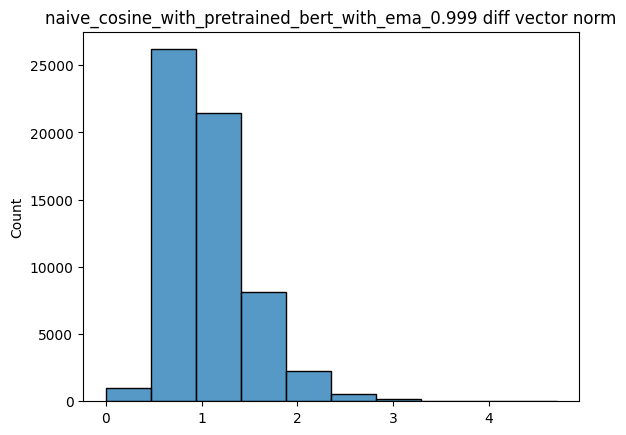

In [34]:
sns.histplot(torch.linalg.vector_norm(vecs, ord=2, dim=1).cpu(), bins=10)
plt.title(f"{path.parts[-1]} diff vector norm")
plt.savefig(path.joinpath("diff vector norm barchart.png"), format="png")

In [35]:
torch.where(vecs.sum(dim=1) != 0)[0].shape

torch.Size([59745])

In [36]:
reducer = umap.UMAP(n_neighbors=15,
                    min_dist=0.2,
                    n_components=3,
                    metric='euclidean',
                    random_state=42)

In [37]:
embedding = reducer.fit_transform(vecs.cpu().numpy())

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Text(0.5, 0.92, 'naive_cosine_with_pretrained_bert_with_ema_0.999 umap_vecdiff')

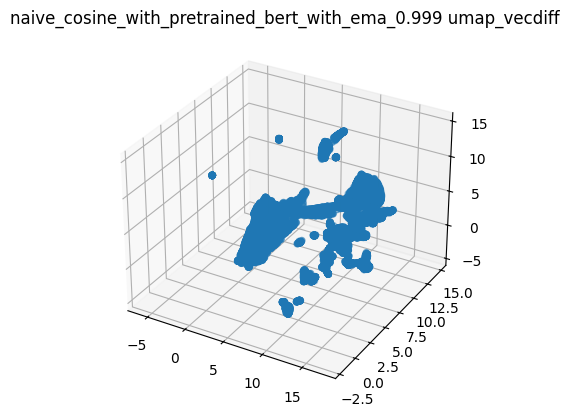

In [38]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax.set_title(f"{path.parts[-1]} umap_vecdiff")
#plt.savefig(path.joinpath("umap_vecdiff.png"), format="png")

In [39]:
vecs_diff = vecs[torch.where(vecs.sum(dim=1) != 0)[0]].cpu()
mn_vec = vecs_diff.mean(dim=0).cpu()

In [40]:
cos = torch.nn.functional.cosine_similarity(vecs_diff, mn_vec.view(1, -1), dim=1)
norm = torch.linalg.vector_norm(vecs_diff, ord=2, dim=1).cpu()

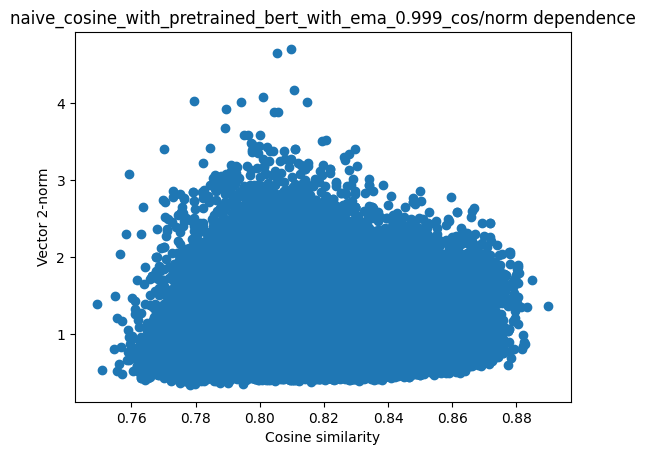

In [41]:
plt.scatter(cos, norm)
plt.xlabel("Cosine similarity")
plt.ylabel("Vector 2-norm")
plt.title(f"{path.parts[-1]}_cos/norm dependence")
plt.savefig(path.joinpath("cos_norm_dep.png"), format="png")

In [ ]:
clusterer = hdbscan.HDBSCAN()

In [ ]:
clusterer.fit(blobs)